## 다이나믹 프로그래밍
다음 환경(**GridWorldEnvironment**)을 가지고 가치 이터레이션, 정책 이터레이션을 구현하세요.

## GridWorldEnvironment
```py
start_point = (0,0)
end_point = (4,4)
gridworld_size = (5,5)
env = GridWorldEnvironment(start_point, end_point, grid_world_size)
```

## Original Code

In [11]:
import numpy as np
from typing import Tuple

class GridWorldEnvironment:
    def __init__(self, start_point:Tuple, end_point:Tuple, grid_world_size:Tuple):
        # 시작점과 끝점을 받는다.
        self.start_point = start_point
        self.end_point = end_point if end_point != (-1,-1) else (grid_world_size[0] + end_point[0],
                                                                 grid_world_size[1] + end_point[1])

        # 그리드 월드의 규격을 받는다.
        self.width, self.height = grid_world_size

        # action dictionary
        self.action_space = ['up', 'down', 'left', 'right']
        self.num_actions = len(self.action_space)
        self.actions = {'up':(-1,0),
                        'down':(1,0),
                        'left':(0,-1),
                        'right':(0,1) }

        # 상태 : 좌표로 나타남
        self.traces = []

        # total states
        self.total_states = []
        for x in range(self.width):
            for y in range(self.height):
                self.total_states.append((x,y))

        # reward
        self.reward = np.zeros(shape=(self.height, self.width)).tolist()
        self.reward[end_point[0]][end_point[1]] = 1

    def render(self):
        # 그리드 월드의 상태를 출력한다.
        self.grid_world = np.full(shape=(self.height, self.width), fill_value=".").tolist()

        last_point = self.traces[-1] # 에이전트가 가장 마지막에 있었던 위치
        traces = list(set(self.traces)) # 중복된 값을 삭제하기 위함
        for trace in traces:
            self.grid_world[trace[0]][trace[1]] = "X"

        self.grid_world[self.start_point[0]][self.start_point[1]] = "S" # start point
        self.grid_world[self.end_point[0]][self.end_point[1]] = "G" # end point
        self.grid_world[last_point[0]][last_point[1]] = "A" # 현재 에이전트의 위치

        # string으로 출력한다.
        grid = ""

        for i in range(self.height):
            for j in range(self.width):
                grid += self.grid_world[i][j]+" "
            grid += "\n"

        print(grid)

    def get_reward(self, state, action_idx):
        next_state = self.state_after_action(state, action_idx)
        return self.reward[next_state[0]][next_state[1]]

    def state_after_action(self, state, action_idx:int):
        action = self.action_space[action_idx]
        row_movement, col_movement = self.actions[action]

        # action에 따라 에이전트 이동
        next_state = (state[0]+row_movement, state[1]+col_movement)
        next_state = self.check_boundary(next_state)

        return next_state

    def check_boundary(self, state):
        state = list(state)
        state[0] = (0 if state[0] < 0 else self.height - 1 if state[0] > self.height - 1 else state[0])
        state[1] = (0 if state[1] < 0 else self.width - 1 if state[1] > self.width - 1 else state[1])
        return tuple(state)

## Own Code
위 환경 클래스를 상속 받아 `env.render` 코드를 구현하세요.

In [12]:
class CustomGridWorld(GridWorldEnvironment): # CustomGridWorld 클래스가 GridWorldEnvironment 클래스를 상속 받음
    def render(self):
        super().render() # 부모 클래스에서 정의된 그리드 출력 기능을 그대로 재사용

        print(f"에이전트의 현재 위치: {self.traces[-1]}")
        print(f"총 이동 횟수: {len(self.traces)}")

        print("Reward Table")
        for row in self.reward:
            print(row)

# CustomGridWorld 클래스의 인스턴스 생성
env = CustomGridWorld(start_point=(0, 0), end_point=(4, 4), grid_world_size=(5, 5))

# 예시 이동 경로 설정
env.traces = [(0, 0), (0,1), (1, 1), (2,1), (2,2), (2, 3), (3, 3), (3, 4), (4, 4)]

# 그리드 월드 상태 출력
env.render()

S X . . . 
. X . . . 
. X X X . 
. . . X X 
. . . . A 

에이전트의 현재 위치: (4, 4)
총 이동 횟수: 9
Reward Table
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 1]


# 01. 정책 이터레이션
- 스켈레톤 코드  
`init` 부를 제외한 나머지 매소드를 채워주세요.

In [13]:
class PolicyIteration:
    def __init__(self,env):
        # about env
        self.env = env
        self.action_space = env.action_space # ['up', 'down', 'left', 'right'] 차례대로 (-1,0) (1,0) (0,-1) (0,1)
        self.num_action = len(self.action_space)

        # value 2d list
        self.value_table = np.zeros(shape = (env.height, env.width)).tolist() # Appendix 1

        # 상하좌우 동일한 확률을 가지는 정책으로 초기화
        self.policy_table = np.full(shape = (env.height, env.width, self.num_action), fill_value = 1/self.num_action).tolist()

        # end state 에서는 어떠한 행동도 할 필요가 없어서 policy table을 비운다.
        self.policy_table[env.end_point[0]][env.end_point[1]] = []

        self.gamma = 0.9 # 할인율

    def get_policy(self, state):
        return self.policy_table[state[0]][state[1]]

    def get_value(self, state):
        return self.value_table[state[0]][state[1]]

    def get_action(self,state):
        policy = self.get_policy(state)
        policy = np.array(policy)
        return np.random.choice(4,1, p=policy)[0]

    def policy_evaluation(self):
        next_value_table = [[0.00] * self.env.width
                            for _ in range(self.env.height)]
        for state in self.env.total_states:
            value = 0.0
            if state == [4,4]:
                next_value_table[state[0]][state[1]] = value
                continue
            for action_idx in range(self.num_action):
                next_state = self.env.state_after_action(state, action_idx)
                reward = self.env.get_reward(state, action_idx)
                next_value = self.get_value(next_state)
                if len(self.get_policy(state)) > 0:
                    value += (self.get_policy(state)[action_idx] *
                          (reward + self.gamma * next_value)) # 정책이 비어 있지 않을 때만 접근
            next_value_table[state[0]][state[1]] = value



        self.value_table = next_value_table


    def policy_improvement(self):
        next_policy = self.policy_table

        for state in self.env.total_states:
            if state == [4, 4]:
                continue

            value_list = []
            result = [0.0, 0.0, 0.0, 0.0]

            for action_idx in range(self.num_action):
                next_state = self.env.state_after_action(state, action_idx)
                reward = self.env.get_reward(state, action_idx)
                next_value = self.get_value(next_state)
                value = reward + self.gamma * next_value
                value_list.append(value)

            max_idx_list = np.argwhere(value_list == np.amax(value_list))
            max_idx_list = max_idx_list.flatten().tolist()
            prob = 1 / len(max_idx_list)

            for idx in max_idx_list:
                result[idx] = prob

            next_policy[state[0]][state[1]] = result

        self.policy_table = next_policy

## 정책 이터레이션 실행
정의한 클래스를 이용해 정책 이터레이션을 실행해 주세요.

In [14]:
# 정책 이터레이션 클래스 초기화 객체 생성?
policy_iteration = PolicyIteration(env)

value_deltas = []

# 정책 이터레이션 실행
max_iterations = 1000 # 최대 반복 횟수
threshold = 1e-4 # 수렴 판단 기준

for i in range(max_iterations):
    old_value_table = np.array(policy_iteration.value_table)

    # 1. 정책 평가
    policy_iteration.policy_evaluation()

    # 2. 정책 발전
    policy_iteration.policy_improvement()

    # 가치 테이블 변화가 매우 작으면 수렴한 것을 판단
    new_value_table = np.array(policy_iteration.value_table)
    delta = np.sum(np.abs(old_value_table - new_value_table))
    value_deltas.append(delta)
    if delta < threshold:
        print(f"정책 이터레이션이 수렴하였습니다.")
        break

else:
    print("최대 반복 횟수에 도달하였습니다.")

# 최종 정책 및 가치 테이블 출력
print("최종 가치 테이블:")
for row in policy_iteration.value_table:
    print(row)

print("최종 정책 테이블:")
for row in policy_iteration.policy_table:
    print(row)

정책 이터레이션이 수렴하였습니다.
최종 가치 테이블:
[4.782933119488692, 5.314374119488692, 5.904864119488693, 6.560964119488693, 7.289964119488694]
[5.314374119488692, 5.904864119488693, 6.560964119488693, 7.289964119488694, 8.099964119488694]
[5.904864119488693, 6.560964119488693, 7.289964119488694, 8.099964119488694, 8.999964119488695]
[6.560964119488693, 7.289964119488694, 8.099964119488694, 8.999964119488695, 9.999964119488695]
[7.289964119488694, 8.099964119488694, 8.999964119488695, 9.999964119488695, 9.999964119488695]
최종 정책 테이블:
[[0.0, 0.5, 0.0, 0.5], [0.0, 0.5, 0.0, 0.5], [0.0, 0.5, 0.0, 0.5], [0.0, 0.5, 0.0, 0.5], [0.0, 1.0, 0.0, 0.0]]
[[0.0, 0.5, 0.0, 0.5], [0.0, 0.5, 0.0, 0.5], [0.0, 0.5, 0.0, 0.5], [0.0, 0.5, 0.0, 0.5], [0.0, 1.0, 0.0, 0.0]]
[[0.0, 0.5, 0.0, 0.5], [0.0, 0.5, 0.0, 0.5], [0.0, 0.5, 0.0, 0.5], [0.0, 0.5, 0.0, 0.5], [0.0, 1.0, 0.0, 0.0]]
[[0.0, 0.5, 0.0, 0.5], [0.0, 0.5, 0.0, 0.5], [0.0, 0.5, 0.0, 0.5], [0.0, 0.5, 0.0, 0.5], [0.0, 1.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0

## 학습에서 중요한 정보
학습이 되고 있는 것을 판단할 수 있는 파라미터를 찾아 시각화해 주세요.

In [15]:
# 가치함수의 변화: delta

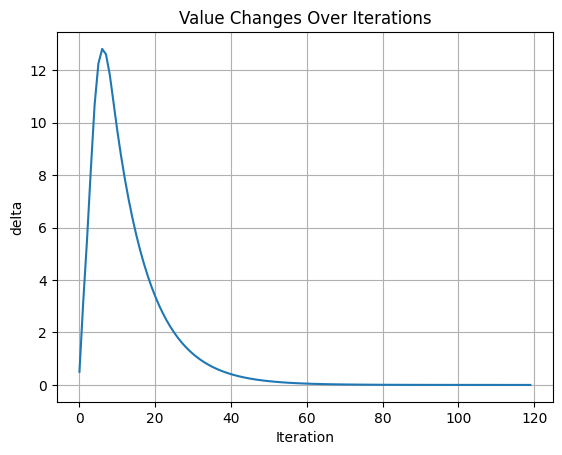

In [16]:
import matplotlib.pyplot as plt

plt.plot(value_deltas)
plt.title("Value Changes Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("delta")
plt.grid(True)
plt.show()


# 02. 가치 이터레이션
- 스켈레톤 코드  
`init` 부를 제외한 나머지 매소드를 채워주세요.

In [17]:
class ValueIteration:
    def __init__(self, env):

        self.env = env
        self.action_space = env.action_space
        self.num_actions = env.num_actions

        # value 2d list
        self.value_table = np.zeros(shape=(env.height, env.width)).tolist()

        self.gamma = 0.9 # 할인율

    def value_iteration(self):
        next_value_table = [[0.0] * self.env.width
                            for _ in range(self.env.height)]

        for state in self.env.total_states:
            if state == [4, 4]:
                next_value_table[state[0]][state[1]] = 0.0
                continue

            # 벨만 최적 방정식
            value_list = []
            for action_idx in range(self.num_actions):
                next_state = self.env.state_after_action(state, action_idx)
                reward = self.env.get_reward(state, action_idx)
                next_value = self.get_value(next_state)
                value_list.append((reward + self.gamma * next_value))

            # 최댓값을 다음 가치함수로 대입
            next_value_table[state[0]][state[1]] = max(value_list)

        self.value_table = next_value_table

    def get_action(self, state):
        if state == [4, 4]:
            return []

        # 모든 행동에 대해 큐함수(보상 + (할인율 * 다음 상태 가치함수))를 계산
        value_list = []
        for action_idx in range(self.num_actions):
            next_state = self.env.state_after_action(state, action_idx)
            reward = self.env.get_reward(state, action_idx)
            next_value = self.get_value(next_state)
            value = (reward + self.gamma * next_value)
            value_list.append(value)

        # 최대 큐함수를 가진 행동(복수일 경우 여러 개)을 반환
        max_idx_list = np.argwhere(value_list == np.amax(value_list))
        action_list = max_idx_list.flatten().tolist()
        return action_list

    def get_value(self, state):
        return self.value_table[state[0]][state[1]]

## 가치 이터레이션 실행
정의한 클래스를 이용해 정책 이터레이션을 실행해 주세요.

In [20]:
# 가치 이터레이션 클래스 초기화 객체 생성?
value_iteration = ValueIteration(env)

value_deltas = []

# 가치 이터레이션 실행
max_iterations = 1000 # 최대 반복 횟수
threshold = 1e-4 # 수렴 판단 기준

for i in range(max_iterations):
    old_value_table = np.array(value_iteration.value_table)

    value_iteration.value_iteration()

    # 가치 테이블 변화가 매우 작으면 수렴한 것을 판단
    new_value_table = np.array(value_iteration.value_table)
    delta = np.sum(np.abs(old_value_table - new_value_table))
    value_deltas.append(delta)
    if delta < threshold:
        print(f"가치 이터레이션이 수렴하였습니다.")
        break

else:
    print("최대 반복 횟수에 도달하였습니다.")

# 최종 정책 및 가치 테이블 출력
print("최종 가치 테이블:")
for row in value_iteration.value_table:
    print(row)

print("최종 정책 테이블:")
for state in env.total_states:
    print(f"상태 {state}의 최적 행동: {value_iteration.get_action(state)}")

가치 이터레이션이 수렴하였습니다.
최종 가치 테이블:
[4.782933119488692, 5.314374119488692, 5.904864119488693, 6.560964119488693, 7.289964119488694]
[5.314374119488692, 5.904864119488693, 6.560964119488693, 7.289964119488694, 8.099964119488694]
[5.904864119488693, 6.560964119488693, 7.289964119488694, 8.099964119488694, 8.999964119488695]
[6.560964119488693, 7.289964119488694, 8.099964119488694, 8.999964119488695, 9.999964119488695]
[7.289964119488694, 8.099964119488694, 8.999964119488695, 9.999964119488695, 9.999964119488695]
최종 정책 테이블:
상태 (0, 0)의 최적 행동: [1, 3]
상태 (0, 1)의 최적 행동: [1, 3]
상태 (0, 2)의 최적 행동: [1, 3]
상태 (0, 3)의 최적 행동: [1, 3]
상태 (0, 4)의 최적 행동: [1]
상태 (1, 0)의 최적 행동: [1, 3]
상태 (1, 1)의 최적 행동: [1, 3]
상태 (1, 2)의 최적 행동: [1, 3]
상태 (1, 3)의 최적 행동: [1, 3]
상태 (1, 4)의 최적 행동: [1]
상태 (2, 0)의 최적 행동: [1, 3]
상태 (2, 1)의 최적 행동: [1, 3]
상태 (2, 2)의 최적 행동: [1, 3]
상태 (2, 3)의 최적 행동: [1, 3]
상태 (2, 4)의 최적 행동: [1]
상태 (3, 0)의 최적 행동: [1, 3]
상태 (3, 1)의 최적 행동: [1, 3]
상태 (3, 2)의 최적 행동: [1, 3]
상태 (3, 3)의 최적 행동: [1, 3]
상태 (3, 4)의 최적

## 학습에서 중요한 정보
학습이 되고 있는 것을 판단할 수 있는 파라미터/요소를 찾아 시각화해 주세요.

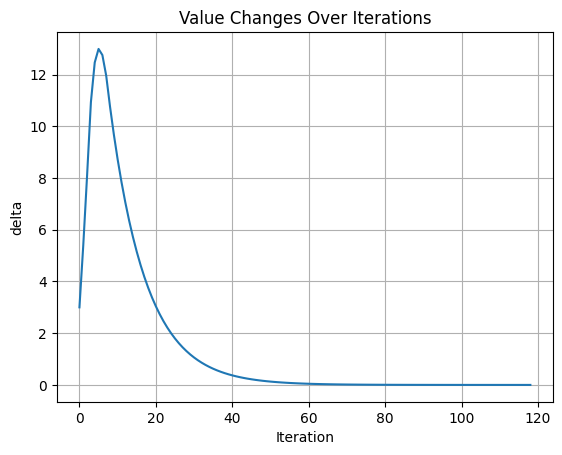

In [21]:
import matplotlib.pyplot as plt

plt.plot(value_deltas)
plt.title("Value Changes Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("delta")
plt.grid(True)
plt.show()
